In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import sim
import util
import torch
from IPython.display import clear_output
from models import GibbsLDA, CollapsedGibbsLDA, PyroLDA

clear_output()

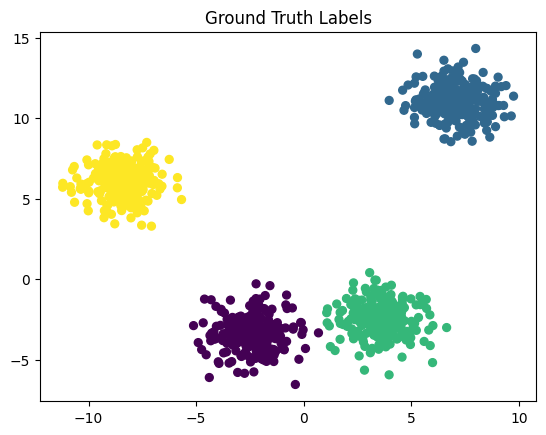

In [464]:
N_SAMPLES = 1000
N_FEATURES = 100
N_TOPICS = 4
SCALE = 1
DISCRETIZE = False
SHUFFLE = True

if DISCRETIZE:
    X, X_labels, vocab = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
else:
    X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
util.visualize_data(X, X_labels, 'Ground Truth Labels')

In [437]:
X.shape

(1000, 100)

In [465]:
from scipy.cluster.vq import kmeans, vq
from sklearn.neighbors import NearestNeighbors

In [466]:
neighbors = NearestNeighbors(n_neighbors=10).fit(X)

In [467]:
_, idx = neighbors.kneighbors(X)
idx

array([[  0, 270, 888, ..., 316, 478, 134],
       [  1, 155, 666, ..., 208, 558, 898],
       [  2, 638, 880, ...,  99, 626, 289],
       ...,
       [997, 492, 139, ..., 597, 518, 770],
       [998, 500, 559, ..., 924, 808, 610],
       [999, 851, 975, ..., 638, 870, 619]])

In [468]:
k = 25
iters = 100
codebook, variance = kmeans(X, k, iters)
codebook.shape

(25, 100)

In [469]:
Y = np.zeros((X.shape[0], 10), dtype=np.int32)
for i in range(Y.shape[0]):
    Y[i], _ = vq(X[idx][i], codebook)
Y

array([[ 4,  4, 24, ...,  4,  9,  4],
       [11, 16, 17, ..., 17, 16, 10],
       [ 4, 24, 24, ..., 24, 24, 22],
       ...,
       [ 7,  7,  7, ...,  2,  5,  7],
       [16, 23, 16, ..., 16, 10, 17],
       [ 4, 24,  4, ..., 24, 24, 24]], dtype=int32)

100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


Score: 0.881


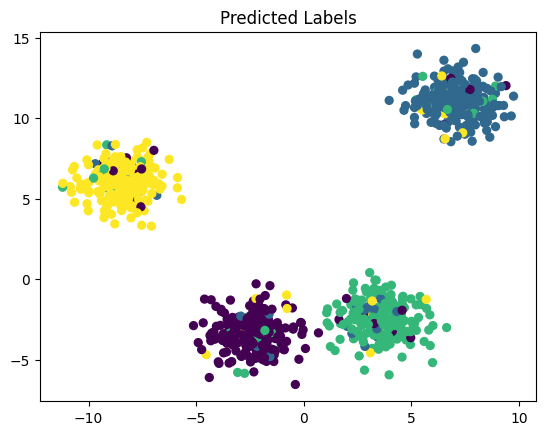

In [472]:
N_STEPS = 50

model = GibbsLDA(N_TOPICS).fit(Y, N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

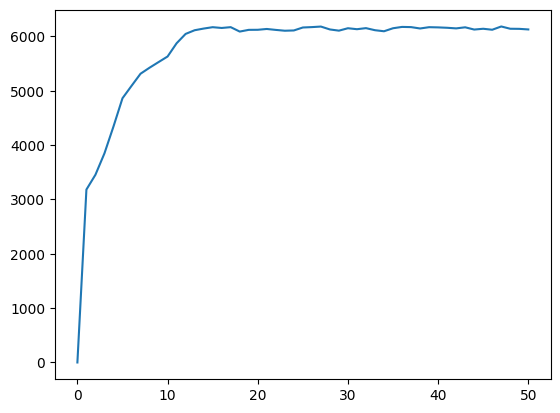

In [473]:
y = model.likelihood_log_
# y = model.loss_log_
x = np.arange(len(y))
plt.plot(x, y);

100%|██████████| 50/50 [00:08<00:00,  6.20it/s]


Score: 0.993


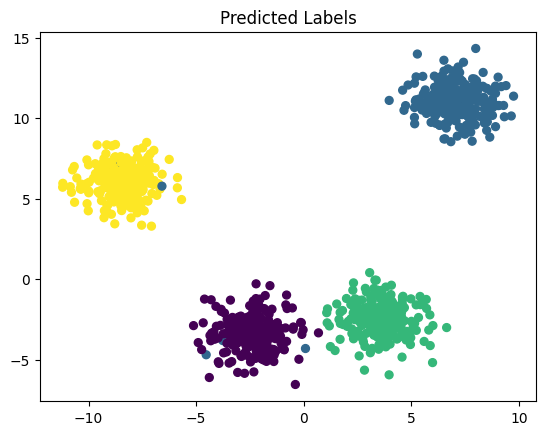

In [474]:
N_STEPS = 50

model = CollapsedGibbsLDA(N_TOPICS).fit(Y, N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

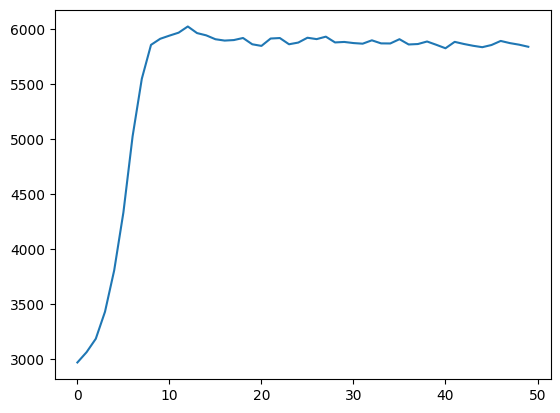

In [475]:
y = model.likelihood_log_
x = np.arange(len(y))
plt.plot(x, y);

100%|██████████| 1000/1000 [00:02<00:00, 345.70it/s]


Score: 1.0


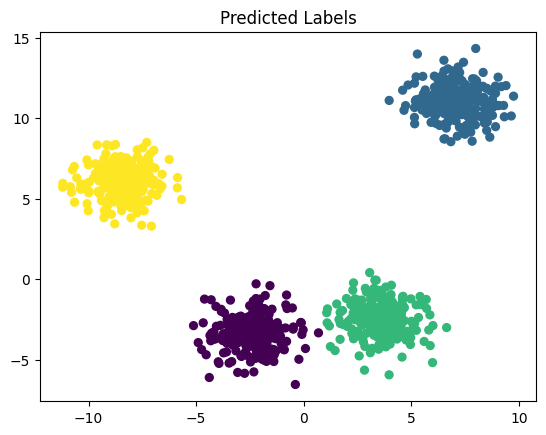

In [476]:
N_STEPS = 1000

pyro.clear_param_store()
Z = torch.tensor(Y).T
model = PyroLDA(N_TOPICS, batch_size=100).fit(Z, N_STEPS, 1e-1)
Y_labels, score = util.evaluate(X_labels, model.transform(Z))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

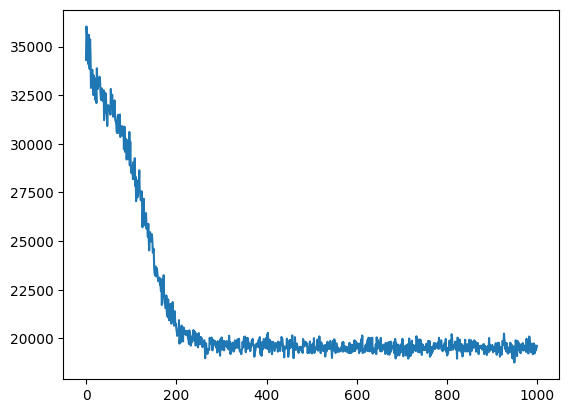

In [477]:
y = model.loss_log_
x = np.arange(len(y))
plt.plot(x, y);